# Using FinBERT for Sentiment Analysis of the Earnings Call Questions and Answers

I ran this locally, no GPU.

Reference: [Financial Sentiment Analysis on Stock Market Headlines With FinBERT & HuggingFace](https://wandb.ai/ivangoncharov/FinBERT_Sentiment_Analysis_Project/reports/Financial-Sentiment-Analysis-on-Stock-Market-Headlines-With-FinBERT-Hugging-Face--VmlldzoxMDQ4NjM0)

In [1]:
QUESTION_FILE_PATH = "csv/ntrs_q1_2020_questions.csv"
ANSWER_FILE_PATH = "csv/ntrs_q1_2020_answers.csv"

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# !pip install pandas torch transformers matplotlib

In [4]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt

/Users/muno/.pyenv/versions/3.8.18/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get questions or answers

In [5]:
def get_qa_list(qa_csv):
  qa_df = pd.read_csv(qa_csv)
  qa_array = np.array(qa_df)
  qa_list = list(qa_array[:,4])

  return qa_list

## Get model and tokenizer

In [6]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

## Inference on the question text with the FinBERT model implemented in HuggingFace

In [7]:
def chunk_list(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def inference(qa_list, qa_type):
  """
  Inference on the text with the FinBERT model implemented in HuggingFace.
  """
  text = None
  if qa_type.lower() == "question":
    text = "Question"
  elif qa_type.lower() == "answer":
    text = "Answer"

  STRIDE = 1 # increase based on data size
  model.eval()

  n=0
  sentiment_df = pd.DataFrame(columns=[text, "Positive", "Negative", "Neutral"])

  for qa in chunk_list(qa_list, STRIDE):

    input = tokenizer(qa, padding = True, truncation = True,  return_tensors='pt')
    outputs = model(**input)
    prediction = torch.nn.functional.softmax(outputs.logits, dim=-1)
    print(f"{n+1}/{int(len(qa_list)/STRIDE)}")

    for q_or_a, pos, neg, neutr in zip(qa, prediction[:, 0].tolist(), prediction[:, 1].tolist(), prediction[:, 2].tolist() ):
      new_row = {text: q_or_a, "Positive": pos, "Negative": neg, "Neutral": neutr}
      sentiment_df = pd.concat([sentiment_df, pd.DataFrame([new_row])], ignore_index=True)
      
    n+=1

  return sentiment_df

## Merge sentiment results to QA datasets

In [8]:
def get_sentiment(row):
  """
  Assigns sentiment label based on the maximum score.
  """
  max_score = max(row["Positive"], row["Negative"], row["Neutral"])
  if max_score == row["Positive"]:
    return "Positive"
  elif max_score == row["Negative"]:
    return "Negative"
  else:
    return "Neutral"

def get_sentiment_df(qa_type):
  qa_list, qa_df, merge_df_on = None, None, None

  # load data
  if qa_type.lower() == "question":
    qa_list = get_qa_list(QUESTION_FILE_PATH)
    qa_df = pd.read_csv(QUESTION_FILE_PATH)
    merge_df_on = "Question"
  elif qa_type.lower() == "answer":
    qa_list = get_qa_list(ANSWER_FILE_PATH)
    qa_df = pd.read_csv(ANSWER_FILE_PATH)
    merge_df_on = "Answer"

  # inference
  sentiment_df = inference(qa_list, qa_type)
  # display(sentiment_df.head())

  # get max sentiment score
  sentiment_df["Sentiment"] = sentiment_df.apply(get_sentiment, axis=1)
  # display(sentiment_df.head())

  # merge with original
  sentiment_df = pd.merge(qa_df, sentiment_df, on=merge_df_on, how='inner')
  # display(sentiment_df.head())

  return sentiment_df

In [9]:
q_sentiment_df = get_sentiment_df("Question")
display(q_sentiment_df.head())

1/15
2/15
3/15
4/15
5/15
6/15
7/15
8/15
9/15
10/15
11/15
12/15
13/15
14/15
15/15


,Question ID,Speaker ID,Speaker Company,Speaker Name,Question,Positive,Negative,Neutral,Sentiment
0,0,3,"Goldman Sachs Group Inc., Research Division",Alexander Blostein,So I wanted to start with your guys' thoughts ...,0.059832,0.039279,0.900889,Neutral
1,1,9,"Evercore ISI Institutional Equities, Research ...",Glenn Paul Schorr,"Wonder if I could ask a question, I could use ...",0.042935,0.027732,0.929333,Neutral
2,2,12,"BofA Merrill Lynch, Research Division",Michael Roger Carrier,"First, can you provide a bit more color on the...",0.070344,0.021193,0.908463,Neutral
3,3,6,"Deutsche Bank AG, Research Division",Brian Bertram Bedell,Maybe just staying with the balance sheet for ...,0.017026,0.841159,0.141815,Negative
4,4,10,"Jefferies LLC, Research Division",Kenneth Michael Usdin,"On the balance sheet, Jason, can you talk thro...",0.035969,0.082739,0.881292,Neutral


In [10]:
a_sentiment_df = get_sentiment_df("Answer")
display(a_sentiment_df.head())

1/24
2/24
3/24
4/24
5/24
6/24
7/24
8/24
9/24
10/24
11/24
12/24
13/24
14/24
15/24
16/24
17/24
18/24
19/24
20/24
21/24
22/24
23/24
24/24


,Answer ID,Speaker ID,Speaker Company,Speaker Name,Answer,Positive,Negative,Neutral,Sentiment
0,0,0,CFO & Executive VP,Jason Jerrome Tyler,"Sure. Alex, let me -- I'll start on the first ...",0.210292,0.021790,0.767918,Neutral
1,0,2,"Chairman, President & CEO",Michael G. O’Grady,"Yes, this is Mike. I would just add to what Ja...",0.189048,0.218728,0.592224,Neutral
2,1,0,CFO & Executive VP,Jason Jerrome Tyler,"Sure, Glenn. Well, let me just start with some...",0.055259,0.077723,0.867017,Neutral
3,1,1,Senior VP & Director of Investor Relations,Mark M. Bette,"Yes. Looking at the entire loan portfolio, ove...",0.049549,0.026874,0.923577,Neutral
4,2,0,CFO & Executive VP,Jason Jerrome Tyler,"Sure. Thanks, Mike. I'll start. Well, first of...",0.057368,0.097863,0.844769,Neutral


## Visualizing sentiment differences

In [11]:
def visualize_sentiment(sentiment_df, qa_type, file_name):
  positive = sentiment_df["Positive"]
  negative = sentiment_df["Negative"]
  neutral = sentiment_df["Neutral"]
  idx = range(1, len(sentiment_df) + 1)  # Create index numbers (1-based)

  # Plotting the variations
  plt.figure(figsize=(10, 6))  # Adjust figure size as needed
  plt.plot(idx, positive, label="Positive", marker='o', color='green')
  plt.plot(idx, negative, label="Negative", marker='s', color='red')
  plt.plot(idx, neutral, label="Neutral", marker='^', color='blue')

  # Adding labels and title
  plt.xlabel(f"{qa_type} Number")
  plt.ylabel("Sentiment Score")
  plt.title(f"Variations in {qa_type} Sentiment Score ({file_name})")

  # Adding legend
  plt.legend()

  # Grid and rotation
  plt.grid(True)

  # Show the plot
  plt.tight_layout()
  plt.show()


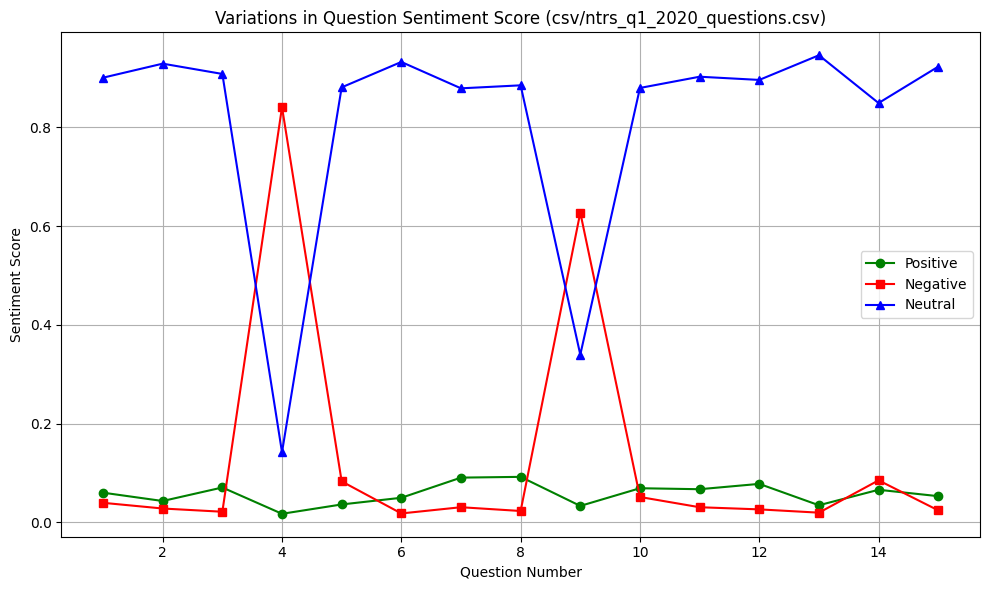

In [12]:
visualize_sentiment(q_sentiment_df, qa_type="Question", file_name=QUESTION_FILE_PATH)

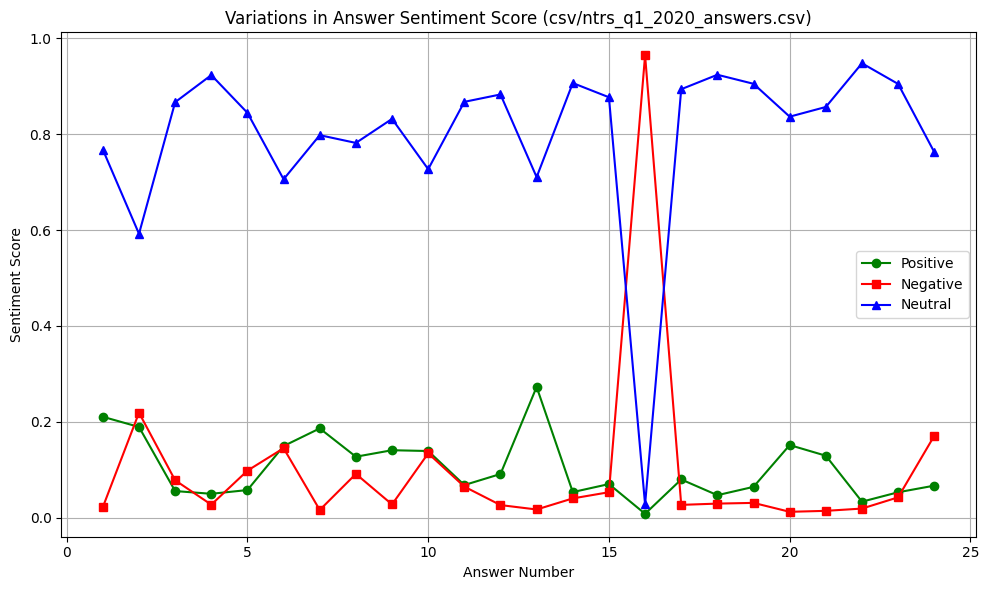

In [13]:
visualize_sentiment(a_sentiment_df, qa_type="Answer", file_name=ANSWER_FILE_PATH)